In [2]:
# Import packages
# DL Packages
import tensorflow as tf
import keras

# Others
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sympy as sym
import seaborn as sns

from sklearn.metrics import confusion_matrix

# Examine the Data:

Begin by downloading the data and looking at shapes:

In [2]:
(Xtrain, Ytrain), (Xtest, Ytest) = tf.keras.datasets.mnist.load_data()

In [3]:
print("Xtrain shape: ", Xtrain.shape)
print("Xtrain min, max: ", Xtrain.min(), Xtrain.max())
print("-----------------------")
print("Ytrain sthape: ", Ytrain.shape)
print("Ytrain classes: ", np.unique(Ytrain))
print("-----------------------")
print("Xtest.shape: ", Xtest.shape)
print("Xtest min, max: ", Xtrain.min(), Xtrain.max())
print("-----------------------")
print("Ytest shape: ", Ytest.shape)
print("Ytest classes: ", np.unique(Ytrain))

Xtrain shape:  (60000, 28, 28)
Xtrain min, max:  0 255
-----------------------
Ytrain sthape:  (60000,)
Ytrain classes:  [0 1 2 3 4 5 6 7 8 9]
-----------------------
Xtest.shape:  (10000, 28, 28)
Xtest min, max:  0 255
-----------------------
Ytest shape:  (10000,)
Ytest classes:  [0 1 2 3 4 5 6 7 8 9]


We have 60,000 training samples and 10,000 test samples. Let's look at some of the data:

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

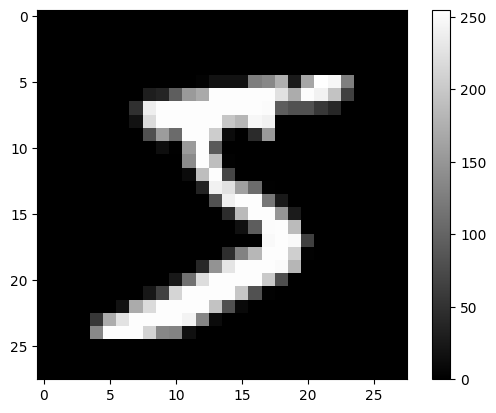

In [4]:
plt.imshow(Xtrain[0], cmap="gray")
plt.colorbar()
Xtrain[0]

As expected, it's a 28x28 integer array (0-255) that corresponds to a grayscale image of a handwritten digit!

Now let's get a sense of the different classes present by plotting one of each:

In [5]:
label_vals = np.unique(Ytrain)
label_vals

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

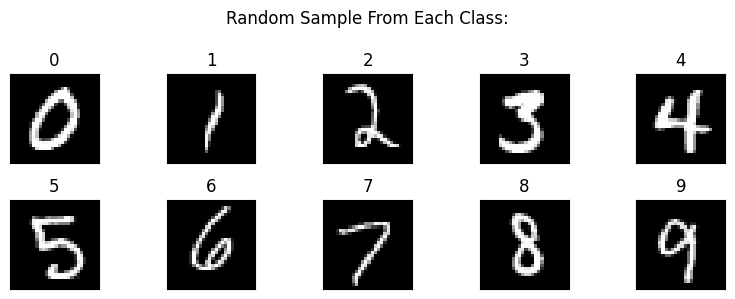

In [6]:
ncols = 5
nrows = 2
f, ax = plt.subplots(nrows=nrows, ncols=ncols)
f.set_size_inches(8,3)
plt.suptitle("Random Sample From Each Class:")
for i in range(nrows):
    for j in range(ncols):
        n = label_vals[i*ncols + j]
        is_n = np.nonzero(Ytrain==n)[0]
        random_i = np.random.choice(is_n)
        ax[i,j].imshow(Xtrain[random_i], origin="upper", cmap="gray")
        ax[i,j].set_aspect(1)
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
        ax[i,j].set_title(n)
plt.tight_layout()

# Pre-Process Data:

First we will normalize the data to be between 0-1, instead of 0-255. We will also use one hot encoding to represent the data labels. To do the one hot encoding, use the code that I made for assignment 2:

In [7]:
Xtrain_norm = Xtrain.astype(float)/np.max(Xtrain)
Xtest_norm = Xtest.astype(float)/np.max(Xtest)
def OHE(labels):

    Y = np.zeros((labels.size, 1), dtype=int)
    unique_vals = np.unique(labels)
    label_map = {}
    for i, val in enumerate(unique_vals):
        label_map[val] = i
    count = 0
    for i, label in enumerate(labels):
        # Assign label
        Y[i] = label_map[label]

    Y_OHE = np.zeros((Y.shape[0], len(label_map)), dtype=int)
    for i in range(Y.shape[0]):
        Y_OHE[i, Y[i]] = 1
    Y = Y_OHE

    return Y_OHE

Ytrain_OHE = OHE(Ytrain)
Ytest_OHE = OHE(Ytest)

Now look at the data, labels:

Ytrain[0]: 5  Ytrain_OHE[0]: [0 0 0 0 0 1 0 0 0 0]


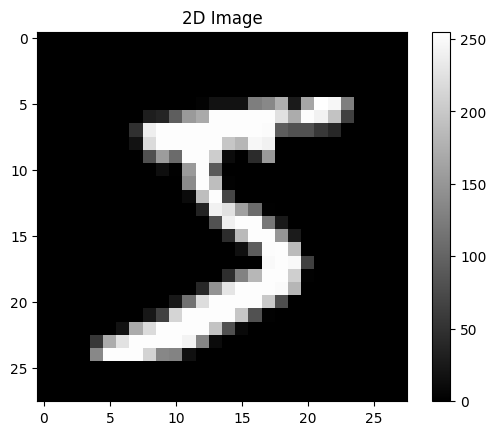

In [8]:
print("Ytrain[0]:", Ytrain[0], " Ytrain_OHE[0]:", Ytrain_OHE[0])
plt.imshow(Xtrain[0], cmap="gray")
plt.title("2D Image")
plt.colorbar();

Looks good! Image is normalized to between 0-1 and 5 is encoded as a 1 in the [5] position. The flattened data seems right, as it's all zeros in the beginning and end of the sequence which corresponds to the top/bottom of the image.

# Make/Train a Network:

In [9]:
input_size = Xtrain[0].shape
flat_size = input_size[0]*input_size[1]
output_size = 10 # one hot encoded label vals
model = keras.models.Sequential([
    keras.Input(shape=input_size),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(flat_size, activation="relu"),
    keras.layers.Dense(flat_size/4, activation="relu"),
    keras.layers.Dense(output_size, activation="softmax")
], name="mnist_dense")
model.build(input_size)
model.compile(optimizer="adam", loss="categorical_crossentropy", 
              metrics=[keras.metrics.CategoricalAccuracy()])
model.summary()

Model: "mnist_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 784)               615440    
                                                                 
 dense_1 (Dense)             (None, 196)               153860    
                                                                 
 dense_2 (Dense)             (None, 10)                1970      
                                                                 
Total params: 771270 (2.94 MB)
Trainable params: 771270 (2.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-11-13 18:09:22.618803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 18:09:22.621563: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 18:09:22.621639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
history = model.fit(Xtrain_norm, Ytrain_OHE, batch_size=1000, epochs=100, validation_data=(Xtest_norm, Ytest_OHE))

Epoch 1/100


2023-11-13 18:09:23.324082: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-13 18:09:23.619863: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff2450f8d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-13 18:09:23.619880: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4500, Compute Capability 8.6
2023-11-13 18:09:23.623074: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-13 18:09:23.630852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-13 18:09:23.670937: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 [==============================] - 1s 4ms/step - loss: 0.4602 - categorical_accuracy: 0.8720 - val_loss: 0.1956 - val_categorical_accuracy: 0.9423
Epoch 2/100
60/60 [==============================] - 0s 2ms/step - loss: 0.1694 - categorical_accuracy: 0.9511 - val_loss: 0.1243 - val_categorical_accuracy: 0.9617
Epoch 3/100
60/60 [==============================] - 0s 2ms/step - loss: 0.1147 - categorical_accuracy: 0.9659 - val_loss: 0.0973 - val_categorical_accuracy: 0.9701
Epoch 4/100
60/60 [==============================] - 0s 2ms/step - loss: 0.0870 - categorical_accuracy: 0.9739 - val_loss: 0.0813 - val_categorical_accuracy: 0.9756
Epoch 5/100
60/60 [==============================] - 0s 2ms/step - loss: 0.0683 - categorical_accuracy: 0.9794 - val_loss: 0.0714 - val_categorical_accuracy: 0.9782
Epoch 6/100
60/60 [==============================] - 0s 2ms/step - loss: 0.0540 - categorical_accuracy: 0.9839 - val_loss: 0.0636 - val_categorical_accuracy: 0.9802
Epoch 7/100
60/60 [===

# Evalute Results:

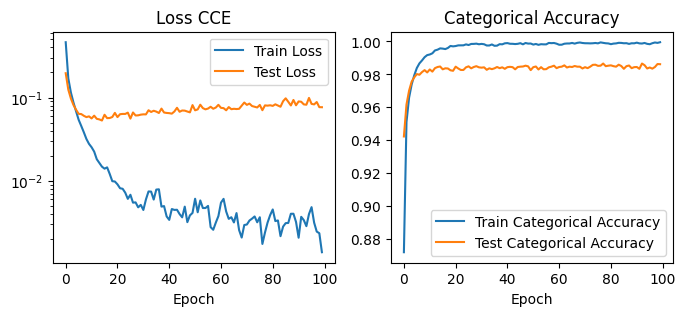

In [11]:
history.history.keys()
f, ax = plt.subplots(ncols=2)
f.set_size_inches(8,3)
ax[0].plot(history.history["loss"], label="Train Loss")
ax[0].set_title("Loss CCE")
ax[0].plot(history.history["val_loss"], label="Test Loss")
ax[0].set_yscale("log")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(history.history["categorical_accuracy"], label="Train Categorical Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Categorical Accuracy")
ax[1].plot(history.history["val_categorical_accuracy"], label="Test Categorical Accuracy")
ax[1].legend();

We see that even though the training loss continues to decrease, we saturate our test loss/accuravey after only a few epochs. With a higher dropout rate we might be able to avoid this.

To plot confusion matrix, again take code from assignment 2:

In [12]:

def plot_confusion_matrix(Y: np.array, pred: np.array, labels=[], savename="", logscale=False):
    """
    Convenience function for generating a confusion Matrix

    Args:
        Y (np.array): Actual labels for the dataset (n rows, 1 column)
        pred (np.array): Predicted labels for the data (n rows, 1 column)
        labels (list of str): class labels
        savename (str, optional): File to save plot to. If none is given shows figure.
                                    Defaults to "".

    Returns:
        confusion matrix
    """
    # Figure out predicted class -- infer from Y and pred the number of classes
    if Y.shape[1] > 1:
        Y_labels = np.zeros(Y.shape[0], dtype=int)
        pred_labels = np.zeros_like(Y_labels)
        for i in range(Y.shape[0]):
            Y_labels[i] = np.argmax(Y[i])
            pred_labels[i] = np.argmax(pred[i])
    else:
        Y_labels = Y
        pred_labels = (Y >= 0.5).astype(int)
    cm = confusion_matrix(Y_labels, pred_labels)
    f, ax = plt.subplots()
    if logscale:
        from matplotlib.colors import LogNorm, Normalize
        sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', norm=LogNorm())
    else:
        sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')
    # labels, title and ticks
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    if not labels:
        labels = np.arange(max(Y.shape[1], 2))
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    if savename != "":
        plt.savefig(savename)
        plt.close(f)
    else:
        plt.show()

    return cm

Plot the confusion matrix with a log colorbar so we can see the nonzero off diagonal entries more easily. Note anything missing is 0.

  1/313 [..............................] - ETA: 12s

313/313 [==============================] - 0s 597us/step


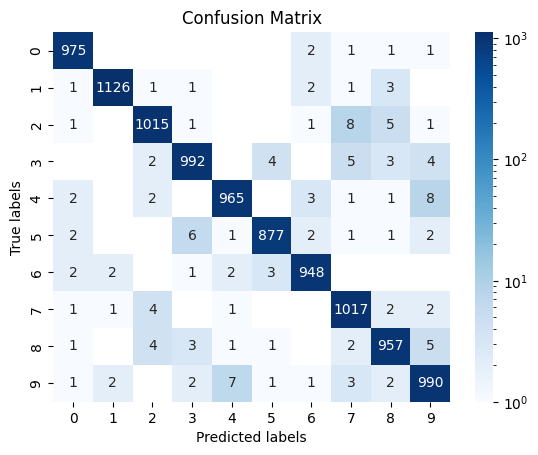

array([[ 975,    0,    0,    0,    0,    0,    2,    1,    1,    1],
       [   1, 1126,    1,    1,    0,    0,    2,    1,    3,    0],
       [   1,    0, 1015,    1,    0,    0,    1,    8,    5,    1],
       [   0,    0,    2,  992,    0,    4,    0,    5,    3,    4],
       [   2,    0,    2,    0,  965,    0,    3,    1,    1,    8],
       [   2,    0,    0,    6,    1,  877,    2,    1,    1,    2],
       [   2,    2,    0,    1,    2,    3,  948,    0,    0,    0],
       [   1,    1,    4,    0,    1,    0,    0, 1017,    2,    2],
       [   1,    0,    4,    3,    1,    1,    0,    2,  957,    5],
       [   1,    2,    0,    2,    7,    1,    1,    3,    2,  990]])

In [13]:
Ypred = model.predict(Xtest_norm)
plot_confusion_matrix(Ytest_OHE, Ypred, logscale=True)

The most confused digits seem to be 4 & 9 and 5 & 3, which makes some sense!